# Scaling up

Originally released as part of a homework in ADA2019.

## Description

[Reddit](https://www.reddit.com/) aka *'the front page of the internet'* is a network of over a million *communities* aka *'subreddits'*, each of which covers a different topic based on people's interests. In other words, it is a *massive* collection of forums (corresponding to the aforementioned communities), where people can share content specific to a given topic or comment on other people’s posts.   

You are reddit's community manager and want to *appoint new moderators*. Because moderating a specific subreddit isn't a full-time job, you want the chosen moderators to moderate multiple subreddits at the same time. To make this choice effective, the moderators shouldn't have to spend too much time getting to know the community and the prevalent communication style, so it makes sense to let moderators moderate subreddits that are similar in communication style and language. At the same time, it also makes sense to let them moderate subreddits that are similar with respect to the participating users, because this allows moderators to track the behavior of individual users over multiple subreddits. For example, some users might only post offensive content once a month on a given subreddit, and therefore fly under the radar with someone moderating only that subreddit. However, considering all the subreddits these users post to, they might post something offensive every day but on different subreddits. Thus, a moderator in charge of all these subreddits would be able to ban such users much more effectively. In the light of the above description, your task is to find out ways to choose moderators considering both the textual content and the users of a subreddit.

### Dataset:
The dataset provided to you includes all the posts of the 15 largest subreddits written as of May 2015.

Reddit posts (provided to you via a [google drive folder](https://drive.google.com/a/epfl.ch/file/d/19SVHKbUTUPtC9HMmADJcAAIY1Xjq6WFv/view?usp=sharing))
```
reddit_posts
 |-- id: id of the post 
 |-- author: user name of the author 
 |-- body: text of the message
 |-- subreddit: name of the subreddit
```

Reddit scores (provided to you via a [google drive folder](https://drive.google.com/a/epfl.ch/file/d/1vr4PolJzTXr6ODSe3ucib5EAyp3rjxec/view?usp=sharing))
```
reddit_scores
 |-- id: id of the post 
 |-- score: score computed as sum of UP/DOWN votes
```

*Note: Jaccard similarity between subreddits represented using either the set of top-1000 words or the set of users can be computed locally (on the driver), however, all the other tasks have to be implemented in Spark.*

## B1. Getting a sense of the data

Start a PySpark instance...

In [13]:
import pyspark
import pyspark.sql
from pyspark.sql import *
from pyspark.sql.functions import *
import numpy as np 
import pandas as pd

conf = pyspark.SparkConf().setMaster("local[*]").setAll([
                                   ('spark.executor.memory', '12g'),  # find
                                   ('spark.driver.memory','4g'), # your
                                   ('spark.driver.maxResultSize', '2G') # setup
                                  ])
# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# create the context
sc = spark.sparkContext

# FIX for Spark 2.x
locale = sc._jvm.java.util.Locale
locale.setDefault(locale.forLanguageTag("en-US"))

spark

... and load the data in a Spark dataframe.

In [14]:
reddit_posts = spark.read.json("messages.json.gz")
reddit_scores = spark.read.json("score.json.gz")

In [15]:
reddit_posts.show()

+--------------------+--------------------+-------+---------------+
|              author|                body|     id|      subreddit|
+--------------------+--------------------+-------+---------------+
|           WyaOfWade|gg this one's ove...|cqug90h|            nba|
|           BEE_REAL_|Nihilum and LG ar...|cqug90p|GlobalOffensive|
|           SlowRolla|Me too. Same hamm...|cqug916|           pics|
|      SenpaiOniichan|well i think new ...|cqug919|leagueoflegends|
|   backwoodsofcanada|That's something ...|cqug91n|  AdviceAnimals|
|       BurntTheToast|Because we aren't...|cqug91p|         videos|
|       starvinmartin|Well yeah. The fi...|cqug91z|            nba|
|         superiorfox|**[STREAMLINK](ht...|cqug92a|            nba|
|           hogsucker|1-She got to be a...|cqug92b|           news|
|        PoopyVampire|Holy shit, I coul...|cqug92e|         movies|
|           Stokest26|Do you get to jus...|cqug92m|            nfl|
|          Drakengard|https://i.imgur.c...|cqug9

In [16]:
reddit_scores.show()

+-------+-----+
|     id|score|
+-------+-----+
|cqug90h|    4|
|cqug90p|    5|
|cqug916|    3|
|cqug919|    1|
|cqug91n|    1|
|cqug91p|    2|
|cqug91z|   21|
|cqug92a|    0|
|cqug92b|  -11|
|cqug92e|    2|
|cqug92m|    4|
|cqug92p|    2|
|cqug930|   -2|
|cqug938|    1|
|cqug93g|    1|
|cqug93p|    1|
|cqug93x|    2|
|cqug94i|    2|
|cqug94t|    3|
|cqug953|   -5|
+-------+-----+
only showing top 20 rows



### B1.1. Identify the most active subreddit

Print the list of subreddits along with the following information:
1. The total number of posts
2. The number of users with at least 1 message
3. The mean message length

*Note: Keep everything in one single dataframe and print the list sorted by number of posts in descending order.*

In [17]:
subreddit_stats = reddit_posts.withColumn("MsgLen", length("body"))\
                              .groupBy("subreddit").agg(
                              count("*").alias("PostperSubR"),
                              countDistinct("id").alias("MsgperSubR"),
                              round(mean("MsgLen"),2).alias("MeanMsgLenperSUbR"))\
                              .sort(desc("PostperSubR"))
subreddit_stats.show()

+---------------+-----------+----------+-----------------+
|      subreddit|PostperSubR|MsgperSubR|MeanMsgLenperSUbR|
+---------------+-----------+----------+-----------------+
|leagueoflegends|    1151287|   1151287|           152.72|
|            nba|     704862|    704862|           106.49|
|          funny|     691139|    691139|           106.82|
|           pics|     564502|    564502|           114.97|
|            nfl|     534345|    534345|           148.97|
|         videos|     511492|    511492|           170.23|
|           news|     477658|    477658|           230.95|
| DestinyTheGame|     471160|    471160|           165.42|
|         soccer|     455215|    455215|           134.42|
|          DotA2|     445154|    445154|           141.49|
|      worldnews|     439417|    439417|           224.94|
|  AdviceAnimals|     411902|    411902|           159.25|
|         hockey|     389329|    389329|            95.37|
|GlobalOffensive|     382017|    382017|           147.2

In [18]:
# # GLOBAL, NOT PER SUBREDDIT!!   

# msg_per_users = reddit_posts.groupBy("id")\
#                                     .agg(count("*").alias("NumMsg"))
# users_1msg_count = msg_per_users.filter(msg_per_users.NumMsg >= 1 ).count()
# print("In total there are {0} users with at least 1 message".format(users_1msg_count))

# reddit_posts = reddit_posts.withColumn("MsgLen", length("body"))

# mean_len = reddit_posts.agg(mean("MsgLen").alias("MeanMsgLen")).collect()[0]["MeanMsgLen"]
# # agg create a df, i need to collect the the first row and first col value. 
# # .collect() → returns a list of Row objects (here, only one row).
# # [0]["MeanMsgLen"] → gets the actual number from that Row.

# print(f"The mean message lenght is {mean_len}")

### B1.2. Identify the largest subreddit

Print *two* different lists of subreddits: ordered by (1) the number of posts, and (2) the number of users. For each subreddit, print the name and the corresponding counts.

Additionally, (3) plot the mean of message length for each subreddit in descending order.

In [19]:
# (1)
subred_post = subreddit_stats.selectExpr(["subreddit","PostperSubR"]).sort("PostperSubR")
subred_post.show()

+---------------+-----------+
|      subreddit|PostperSubR|
+---------------+-----------+
|         movies|     354601|
|GlobalOffensive|     382017|
|         hockey|     389329|
|  AdviceAnimals|     411902|
|      worldnews|     439417|
|          DotA2|     445154|
|         soccer|     455215|
| DestinyTheGame|     471160|
|           news|     477658|
|         videos|     511492|
|            nfl|     534345|
|           pics|     564502|
|          funny|     691139|
|            nba|     704862|
|leagueoflegends|    1151287|
+---------------+-----------+



In [20]:
# (2)
subred_users = subreddit_stats.selectExpr(["subreddit","MsgperSubR"]).sort("MsgperSubR")
subred_users.show()

+---------------+----------+
|      subreddit|MsgperSubR|
+---------------+----------+
|         movies|    354601|
|GlobalOffensive|    382017|
|         hockey|    389329|
|  AdviceAnimals|    411902|
|      worldnews|    439417|
|          DotA2|    445154|
|         soccer|    455215|
| DestinyTheGame|    471160|
|           news|    477658|
|         videos|    511492|
|            nfl|    534345|
|           pics|    564502|
|          funny|    691139|
|            nba|    704862|
|leagueoflegends|   1151287|
+---------------+----------+



Text(0.5, 1.0, 'Mean Message Lenght per Subreddit')

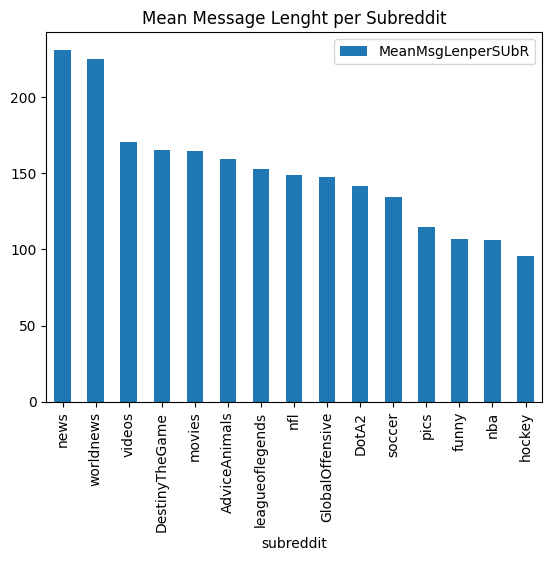

In [21]:
# (3)
subred_meanlen = subreddit_stats.selectExpr(["subreddit","MeanMsgLenperSUbR"]).sort(desc("MeanMsgLenperSUbR"))
subred_meanlen_pd = subred_meanlen.toPandas()
subred_meanlen_pd.head(14)
subred_meanlen_pd.plot(kind='bar', x='subreddit',y='MeanMsgLenperSUbR').set_title("Mean Message Lenght per Subreddit")


### B1.3. Identify the subreddit with the highest average score

Print the list of subreddits sorted by their average content scores.

In [22]:
redd_join = reddit_posts.join(reddit_scores, 
                                          reddit_posts.id == reddit_scores.id)
#redd_join.show()

subred_scores = redd_join.groupBy("subreddit")\
                         .agg(round(mean("score"),2).alias("AvgScoreperSubR"))\
                         .selectExpr(["subreddit","AvgScoreperSubR"])\
                         .sort(desc("AvgScoreperSubR"))
subred_scores.show()

+---------------+---------------+
|      subreddit|AvgScoreperSubR|
+---------------+---------------+
|         videos|          12.65|
|           pics|          12.22|
|          funny|          12.04|
|  AdviceAnimals|          11.25|
|         soccer|          10.63|
|         movies|           9.82|
|            nfl|           9.05|
|            nba|           9.03|
|           news|           8.67|
|      worldnews|           7.87|
|         hockey|           6.52|
|leagueoflegends|           5.98|
|          DotA2|           4.88|
|GlobalOffensive|           4.35|
| DestinyTheGame|           3.03|
+---------------+---------------+



## B2. Moderator assignment based on Subreddit Textual Content

Different subreddits follow different communication styles inherent in the topic and the community. Having said that, the goal is to discover similar subreddits by only looking at the *words* present in the posted messages. Once such a list of similar subreddits is identified, an appropriately chosen moderator can then be assigned to all these subreddits.

Specifically, the task boils down to computing a similarity score between two subreddits based on the *words* present in their textual content. Your first idea is to use the *Jaccard similarity*, which is defined as the size of the intersection of two sets divided by the size of their union.

$Jaccard(A,B) = \frac{|A \cap B|}{|A \cup B|}$

In [23]:
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

### B2.1.
The first step requires constructing a set representation of each subreddit. The goal is to represent each subreddit as a *set of words* existing in the messages posted on that subreddit. Compute the 50,000 most frequent words across all the provided subreddits. Construct a representation for each subreddit by retaining only the words found in the previously identified set of 50,000 frequent words.

Some rules:
 * Words are defined as tokens matching the regular expression `\W`
 * Remove all the stop-words (English language)

*Note: You might find the [RegexTokenizer](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.RegexTokenizer.html) and the [StopWordsRemover](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StopWordsRemover.html) utilities available in the package pyspark.ml useful for this task as they help you in transforming the features and removing stopwords.*

In [24]:
from pyspark.ml.feature import RegexTokenizer,StopWordsRemover

# (1) Tokenizing
reTokenizer = RegexTokenizer(inputCol="body", outputCol="allW",pattern="\W")

# inputCol="body" → the column containing the text you want to tokenize (your messages).
# outputCol="allW" → the new column that will store the list of tokens (words).
# pattern="\\W" → the regex used for splitting. 
# \W (uppercase W) = non-word character. Matches anything that is not a letter, digit, or underscore
# \\W → in Python strings you need double backslash to escape it

df_withwords = reTokenizer.transform(reddit_posts)

# (2) Remove Stop words
sw_remover = StopWordsRemover(inputCol="allW",outputCol="WnoSW")
df_withtokens = sw_remover.transform(df_withwords).drop("allW", "MsgLen")

df_withtokens.show(5)

+-----------------+--------------------+-------+---------------+--------------------+
|           author|                body|     id|      subreddit|               WnoSW|
+-----------------+--------------------+-------+---------------+--------------------+
|        WyaOfWade|gg this one's ove...|cqug90h|            nba|[gg, one, watch, ...|
|        BEE_REAL_|Nihilum and LG ar...|cqug90p|GlobalOffensive|[nihilum, lg, sig...|
|        SlowRolla|Me too. Same hamm...|cqug916|           pics|   [hammock, fabric]|
|   SenpaiOniichan|well i think new ...|cqug919|leagueoflegends|[well, think, new...|
|backwoodsofcanada|That's something ...|cqug91n|  AdviceAnimals|[something, hear,...|
+-----------------+--------------------+-------+---------------+--------------------+
only showing top 5 rows



In [25]:
# (3) Compute the 50k most frequent words across all subreddits
all_words = df_withtokens.select(explode("WnoSW").alias("word"))
# explode from id | WnoSW
#               1 | [Hello, Leti]
#
# become       id | word
#               1 | Hello
#               1 | Leti
 
# all_words.show()
top50k = all_words.groupBy('word')\
                  .agg(count('*').alias('tot')).limit(50000)\
                  .sort(desc('tot'))
top50k.show()


+---------+------+
|     word|   tot|
+---------+------+
|     even|432973|
|    still|326814|
|      got|293313|
|       us|209109|
|    watch|185945|
|      two|158184|
|      amp|152829|
|      day|139669|
|     used|118074|
|   anyone|107741|
|     hope| 79462|
|      hit| 68767|
|        7| 64004|
|    sense| 63733|
|   happen| 62603|
|      jpg| 60319|
|basically| 55399|
|   thread| 53487|
|   taking| 51251|
|    often| 49496|
+---------+------+
only showing top 20 rows



In [26]:
# (4) Number of word in top50k per Subreddit 
# all word df with the info related to the subreddit
all_words_sub = df_withtokens.select('subreddit', explode("WnoSW").alias("word")).distinct()
all_words_sub.show()

+---------------+---------+
|      subreddit|     word|
+---------------+---------+
|         videos|forebears|
|         videos|    riots|
|         videos|     sure|
|           news| sleeping|
|          DotA2|   modify|
|leagueoflegends|     gold|
|         movies|   coming|
|leagueoflegends|     case|
|leagueoflegends|    offer|
|  AdviceAnimals|      big|
|         videos|   points|
|            nfl|    board|
|leagueoflegends|   across|
|          DotA2|     aren|
|         videos|     bait|
|         hockey|  penalty|
|leagueoflegends|      isn|
|           news|     kyle|
| DestinyTheGame|   pocket|
|         hockey|     lame|
+---------------+---------+
only showing top 20 rows



In [27]:
top_words_list = [row.word for row in top50k.collect()] 
sub_words_top50k = all_words_sub.filter(col("word").isin(top_words_list))

subred = sub_words_top50k.groupBy('subreddit')\
                        .agg(collect_set("word").alias('word'))
subred.show(5)

+-------------+--------------------+
|    subreddit|                word|
+-------------+--------------------+
|       hockey|[unclench, librar...|
|       videos|[mccarthyism, unc...|
|        DotA2|[mmmmmmmmmissing,...|
|         news|[mccarthyism, woo...|
|AdviceAnimals|[mccarthyism, unc...|
+-------------+--------------------+
only showing top 5 rows



### B2.2.
* Compute the Jaccard similarity between all the subreddits using the set representation obtained in step **B2.1.**, and plot in a heatmap the similarity values of all the pairs of subreddits.
* Analyze this plot and discuss your observations. Do you observe that subreddits corresponding to similar topics possess higher Jaccard similarity?
* Provide detailed interpretations of the obtained results. Specifically,
    - Explain the limitations of your conclusions, and discuss the potential reasons.
    - Explain the potential problems with the Jaccard similarity function.

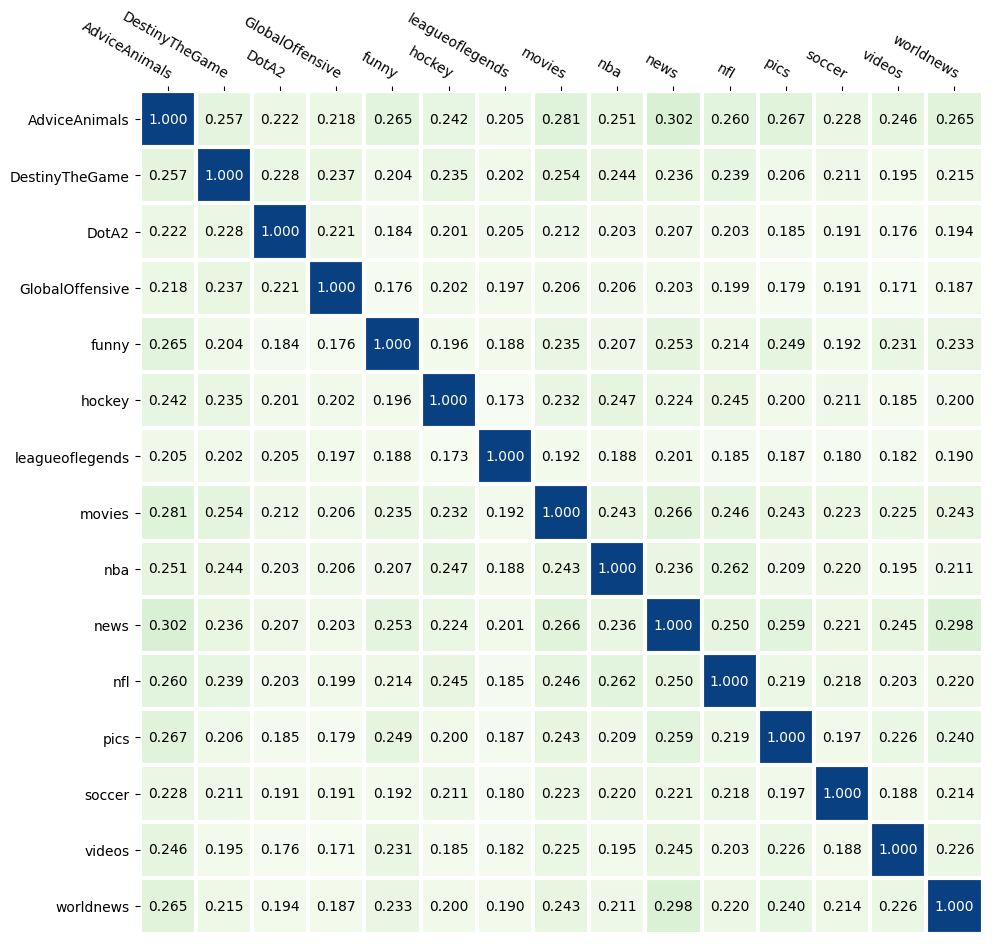

In [28]:
similarities = []
for sr1 in subred.collect():
    for sr2 in subred.collect():
        similarities.append([sr1['subreddit'],sr2['subreddit'],jaccard_similarity(sr1['word'],sr2['word'])])

from hw2_utils import plot_heatmap
sim_mtx_word = pd.DataFrame(similarities).pivot(index=0,columns=1,values=2)
plot_heatmap(sim_mtx_word)

**Do you observe that subreddits corresponding to similar topics possess higher Jaccard similarity?**
Yes, high similiarty cna be seen between soccer, nba and hockey. 

**Explain the limitations of your conclusions, and discuss the potential reasons.**
**Explain the potential problems with the Jaccard similarity function.**
- If a subreddit has few posts, it may appear less similar even if the topics are related.
- Jaccard treats all words equally, ignoring how often a word occurs.
- Jaccard only compares exact words, not meaning. e.g. soccer and foootball do not increase similarity. 
- using only the top 50k words reduces noise but may remove words that are important for distinguishing subreddits.


### B2.3.

* Alternatively, compute the 1000 most frequent words for each subreddit, construct its representation as the set of top-1000 words, and print a heatmap with the Jaccard similarity like in step **B2.2.**.
* Explain your observations in detail: how and why is this new result different from the one obtained in **B2.2.**?

*Note: Use the same rules specified in B2.1: words tokenized with the regex \W and stop-words removed*

In [ ]:
top1k = all_words.groupBy('word')\
                  .agg(count('*').alias('tot')).limit(1000)\
                  .sort(desc('tot'))
top_words_list_1k = [row.word for row in top1k.collect()] 
sub_words_top1k = all_words_sub.filter(col("word").isin(top_words_list_1k))

subred1k = sub_words_top1k.groupBy('subreddit')\
                        .agg(collect_set("word").alias('word'))

In [ ]:
similarities1k = []
for sr1 in subred1k.collect():
    for sr2 in subred1k.collect():
        similarities.append([sr1['subreddit'],sr2['subreddit'],jaccard_similarity(sr1['word'],sr2['word'])])

from hw2_utils import plot_heatmap
sim_mtx_word_1k = pd.DataFrame(similarities1k,columns=["subreddit_1", "subreddit_2", "jaccard"]).pivot(    index="subreddit_1",
    columns="subreddit_2",
    values="jaccard")
plot_heatmap(sim_mtx_word_1k)

## B3. Moderator assignment based on Subreddit Users

Subreddits can be seen as communities of people interacting about a common topic. As an alternative to the *textual content* based similarity in **B2**, your task here is to validate if similarity between two subreddits can be measured based on their participating users.

Of course users are not monothematic, and they interact with multiple subreddits. In this task, we are specifically interested in observing the amount of overlap across different subreddits based on their participating users. Similar to **B2**, the overlap is measured using the *Jaccard similarity*.


### B3.1.
Construct a set representation of each subreddit as the users that posted at least one time in that subreddit.

Some users are very talkative and active across different topics. Print the username of the person that posted in the maximum number of subreddits. *Note that users who posted at least once in a subreddit are considered as participant of that subreddit.*

In [36]:
sr_users = reddit_posts.groupBy("subreddit") \
                              .agg(collect_set("author").alias("users"))
sr_users.show()

+---------------+--------------------+
|      subreddit|               users|
+---------------+--------------------+
|         hockey|[halpinator, Musi...|
|         videos|[Th_Ghost_of_Bob_...|
|          DotA2|[robikasztar, Box...|
|           news|[Almostcomatose, ...|
|  AdviceAnimals|[Mittelstrahl, co...|
| DestinyTheGame|[thefrabbot, rxni...|
|           pics|[LadyCoru, first_...|
|      worldnews|[Almostcomatose, ...|
|            nfl|[ThatImpalerGuy, ...|
|         soccer|[UkuleleSean, ale...|
|GlobalOffensive|[viktor89, Kwadra...|
|leagueoflegends|[VegemilB, iccaru...|
|         movies|[LadyCoru, gfdsag...|
|            nba|[ThatImpalerGuy, ...|
|          funny|[LadyCoru, Almost...|
+---------------+--------------------+



In [37]:
sr_users_exploded = sr_users.select("subreddit",explode("users").alias("user"))
sr_per_users = sr_users_exploded.groupBy("user").agg(countDistinct("*").alias("NumSubRperUser")).sort(desc("NumSubRperUser"))
# sr_per_users.show()
sr_per_users.collect()[0]

Row(user='whispen', NumSubRperUser=15)

### B3.2.

* Compute the Jaccard similarity between all the subreddits using the set representation obtained in step **B3.1.**, and visualise it similar to **B2**.
* Analyze this plot, identify highly similar pairs of subreddits, and clearly describe your observations.

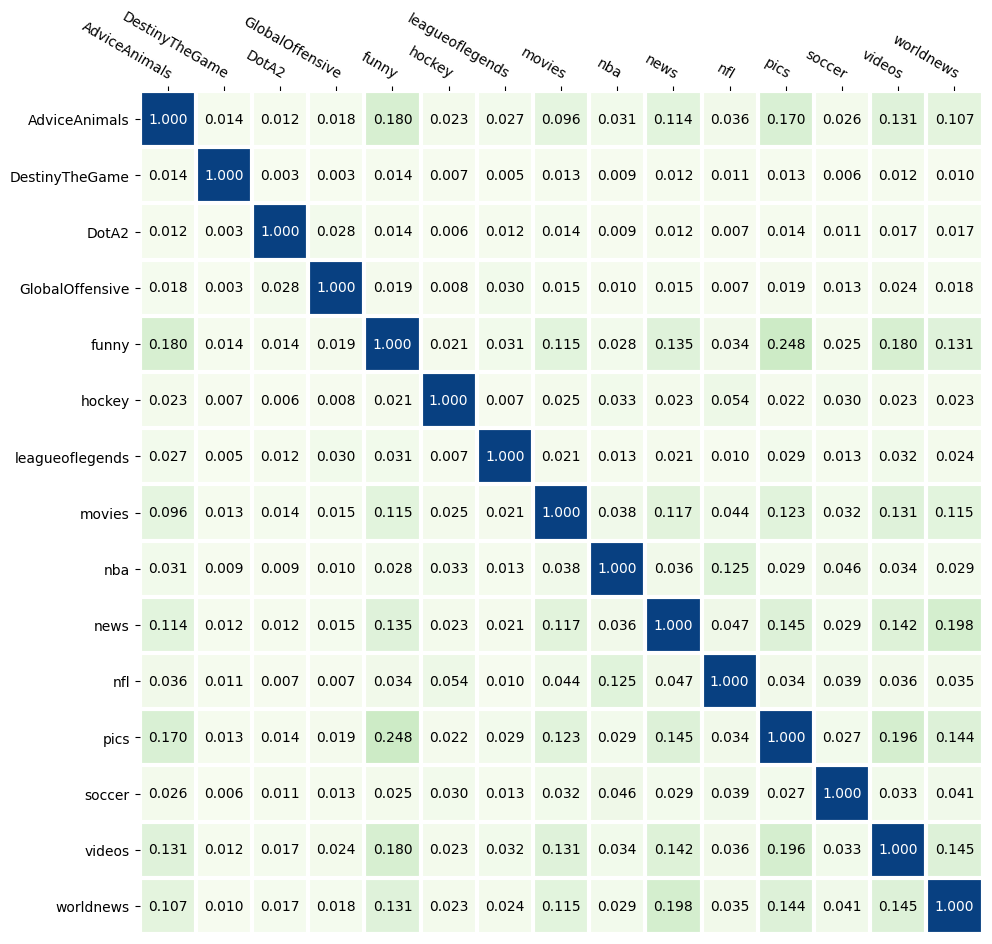

In [38]:
similarities = []
for sr1 in sr_users.collect():
    for sr2 in sr_users.collect():
        similarities.append([sr1['subreddit'],sr2['subreddit'],jaccard_similarity(sr1['users'],sr2['users'])])

from hw2_utils import plot_heatmap
sim_mtx_user = pd.DataFrame(similarities).pivot(index=0,columns=1,values=2)
plot_heatmap(sim_mtx_user)

Similarities are wekear than B2.3. Same problems as before.

## B4. Language vs. Users similarity
    
* Visualize the similarity scores based on word (**B2.3.**) and user (**B3**) similarity on the x and y axes respectively for the subreddit `NBA` compared to all the other subreddits. Do some semantically meaningful groups emerge? Provide clear explanataions of your observations.
* Furthermore, do you observe differences in similarities between various sports-related subreddits in the dataset? Please provide explanations of the reasons behind these differences, if any!

Text(0.5, 1.0, 'NBA similarity')

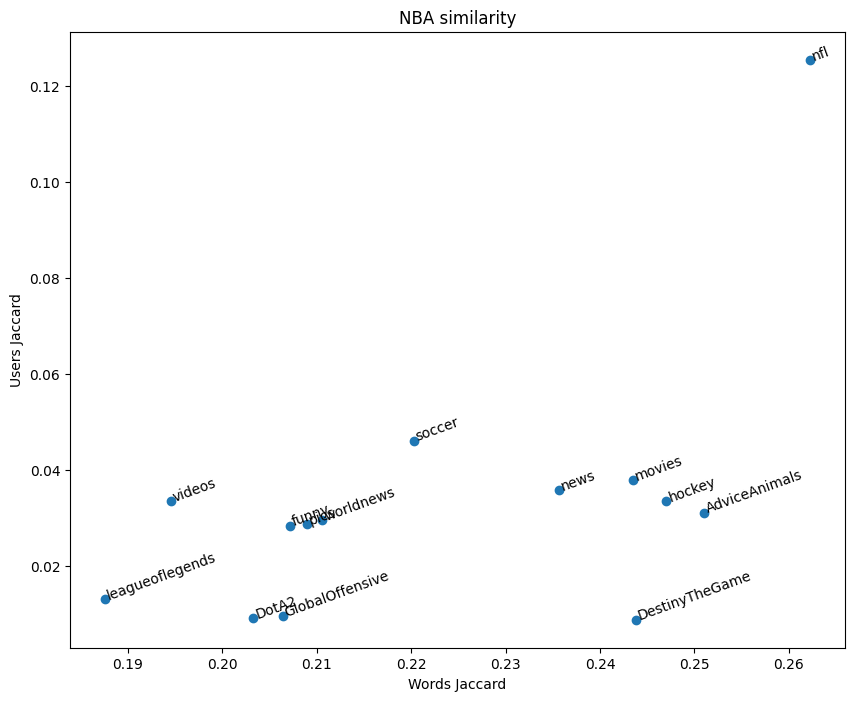

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,8))

u = sim_mtx_user[sim_mtx_user.index == 'nba'].drop('nba', axis=1).to_numpy()[0]
w = sim_mtx_word[sim_mtx_word.index == 'nba'].drop('nba', axis=1).to_numpy()[0]
ax = plt.scatter(w, u)

c=sim_mtx_user[sim_mtx_user.index == 'nba'].drop('nba', axis=1).columns.tolist()

for i in range(0, len(u)):
    plt.annotate(c[i], xy=(w[i], u[i]), rotation=20)
    
plt.xlabel("Words Jaccard")
plt.ylabel("Users Jaccard")
plt.title("NBA similarity")